In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv("climate_posts_clean.csv")

# Convert boolean sentiment to categorical labels
data['sentiment'] = data['positive_sentiment'].map({True: 'positive', False: 'negative'})

# Get 500 random samples (if you want to work with a subset)
sample_data = data.sample(n=500, random_state=42)  # Remove this line if you want to use full dataset

# # First split: separate out 10% for validation
# train_dev_data, val_data = train_test_split(sample_data, test_size=0.1, random_state=42)
#
# # Second split: split remaining 90% into 80% train and 20% test (which becomes 72% and 18% of original)
# train_data, test_data = train_test_split(train_dev_data, test_size=0.2222, random_state=42)  #

# First split: separate out 10% for validation
train_dev_data, val_data = train_test_split(sample_data, test_size=0.1, random_state=42, stratify=sample_data['sentiment'])

# Second split: split remaining 90% into 90% train and 10% test (which becomes 72% and 18% of original)
train_data, test_data = train_test_split(train_dev_data, test_size=0.1111, random_state=42, stratify=train_dev_data['sentiment'])  # 0.1111 ≈ (10%/90%)

print(f"Training samples: {len(train_data)} ({len(train_data)/len(sample_data):.1%} of total)")
print(f"Testing samples: {len(test_data)} ({len(test_data)/len(sample_data):.1%} of total)")
print(f"Validation samples: {len(val_data)} ({len(val_data)/len(sample_data):.1%} of total)")

# Verify the splits add up correctly
assert len(train_data) + len(test_data) + len(val_data) == len(sample_data)

Training samples: 400 (80.0% of total)
Testing samples: 50 (10.0% of total)
Validation samples: 50 (10.0% of total)


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# # Create ML pipeline
# ml_model = Pipeline([
#     ('tfidf', TfidfVectorizer(
#         max_features=5000,
#         ngram_range=(1, 2),
#         stop_words='english',
#     )),
#     ('clf', LogisticRegression(
#         max_iter=1000,
#         random_state=42,
#         class_weight='balanced'
#     ))
# ])
#
# # Train model
# ml_model.fit(train_data['text'], train_data['sentiment'])
#
# # Evaluate
# ml_preds = ml_model.predict(test_data['text'])
# print("Machine Learning Model Performance:")
# print(classification_report(test_data['sentiment'], ml_preds))
# # Predictions and evaluation
#
# val_pred = ml_model.predict(val_data['text'])
# print("\nValidation Set Performance:")
# print(classification_report(val_data['sentiment'], val_pred))

# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid for tuning
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

# Grid search with 10-fold cross-validation on training data
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(train_data['text'], train_data['sentiment'])

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on validation set
val_preds = grid_search.predict(val_data['text'])
print("\nValidation Set Performance:")
print(classification_report(val_data['sentiment'], val_preds))

# Evaluate on test set
test_preds = grid_search.predict(test_data['text'])
print("\nTest Set Performance:")
print(classification_report(test_data['sentiment'], test_preds))

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3)}
Best cross-validation accuracy: 0.6350

Validation Set Performance:
              precision    recall  f1-score   support

    negative       0.65      0.56      0.60        27
    positive       0.56      0.65      0.60        23

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.61      0.60      0.60        50


Test Set Performance:
              precision    recall  f1-score   support

    negative       0.63      0.63      0.63        27
    positive       0.57      0.57      0.57        23

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50



In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_predict(text):
    score = analyzer.polarity_scores(text)['compound']
    return 'positive' if score >= 0 else 'negative'

# Apply VADER
vader_preds = test_data['text'].apply(vader_predict)

# Compare with your existing scores
test_data['vader_score'] = test_data['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
test_data['vader_pred'] = vader_preds

print("\nVADER Performance:")
print(classification_report(test_data['sentiment'], vader_preds))

# Compare with your existing sentiment scores
print("\nComparison with existing scores:")
print(test_data[['text', 'raw_sentiment_score', 'positive_sentiment', 'vader_score', 'vader_pred']].head(10))


VADER Performance:
              precision    recall  f1-score   support

    negative       1.00      0.65      0.79        52
    positive       0.73      1.00      0.84        48

    accuracy                           0.82       100
   macro avg       0.86      0.83      0.82       100
weighted avg       0.87      0.82      0.82       100


Comparison with existing scores:
                                                    text  raw_sentiment_score  \
21769  I could never understand the requirement for a...               0.7717   
56289  using the URL hotlink in the posting interface...              -0.3182   
27252  My cat is right here with me it was never in a...               0.0000   
31183  Just trying to help you out there You keep on ...               0.8088   
16106  No not really an attack I do comprehend quite ...               0.6322   
10476  a http mnn earth matters climate weather stori...              -0.4019   
11839  The climate changed rapidly before because of

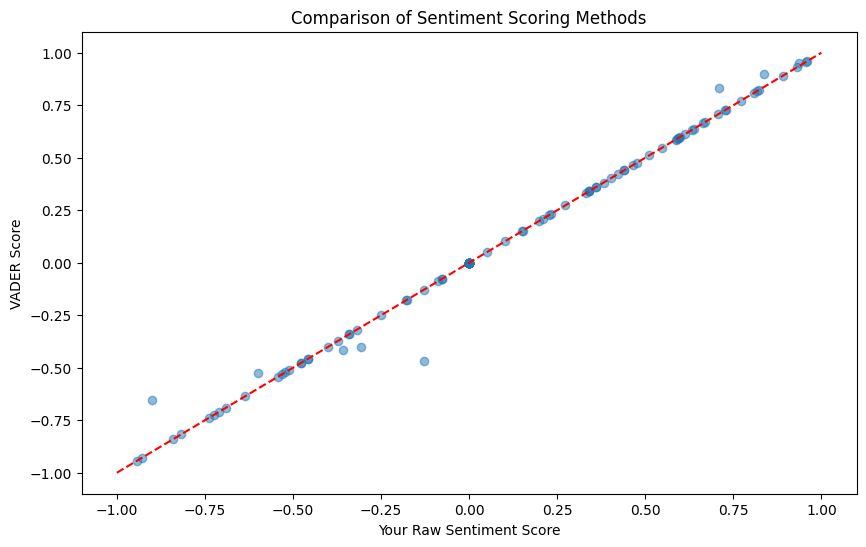

In [30]:
# Compare VADER with your raw_sentiment_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(test_data['raw_sentiment_score'], test_data['vader_score'], alpha=0.5)
plt.xlabel('Your Raw Sentiment Score')
plt.ylabel('VADER Score')
plt.title('Comparison of Sentiment Scoring Methods')
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect agreement line
plt.show()